In [2]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Data
- [Training set data](https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip)
- [Test set data](https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip)
- [Prediction data](https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-validation.zip)

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [8]:
import gdown

dataset_path = "../../data/RPS/"

gdown.download("https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip", datapath, quiet=False)
gdown.download("https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip", datapath, quiet=False)
gdown.download("https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-validation.zip", datapath, quiet=False)


Downloading...
From: https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
To: /Users/olestole/code/kurs/tensorflow_specialty/personalExperiments/data/RPS/rps-test-set.zip
100%|██████████| 29.5M/29.5M [00:06<00:00, 4.26MB/s]
Downloading...
From: https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
To: /Users/olestole/code/kurs/tensorflow_specialty/personalExperiments/data/RPS/rps.zip
100%|██████████| 201M/201M [00:38<00:00, 5.20MB/s]
Downloading...
From: https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-validation.zip
To: /Users/olestole/code/kurs/tensorflow_specialty/personalExperiments/data/RPS/rps-validation.zip
100%|██████████| 6.62M/6.62M [00:01<00:00, 3.59MB/s]


'/Users/olestole/code/kurs/tensorflow_specialty/personalExperiments/RPS../../data/RPS/rps-validation.zip'

In [3]:
def extract_zip(zip_path, dest_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dest_path)

# Extract the zip files for training and validation
extract_zip(f"{os.path.join(dataset_path, 'rps.zip')}", dataset_path)
extract_zip(f"{os.path.join(dataset_path, 'rps-test-set.zip')}", dataset_path)

In [4]:
train_path = os.path.join(dataset_path, 'rps')
validation_path = os.path.join(dataset_path, 'rps-test-set')

train_rock_path = os.path.join(train_path, 'rock')
train_paper_path = os.path.join(train_path, 'paper')
train_scissors_path = os.path.join(train_path, 'scissors')

train_rock_images = [os.path.join(train_rock_path, f) for f in os.listdir(train_rock_path)]
train_paper_images = [os.path.join(train_paper_path, f) for f in os.listdir(train_paper_path)]
train_scissors_images = [os.path.join(train_scissors_path, f) for f in os.listdir(train_scissors_path)]

print(f"Training images: {len(train_rock_images) + len(train_paper_images) + len(train_scissors_images)}")

Training images: 2520


(300, 300, 4)


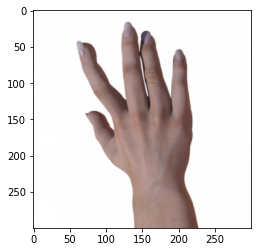

In [7]:
# Look at some of the pictures
image = mpimg.imread(np.random.choice(train_paper_images))
print(image.shape)
plt.imshow(image)
plt.show()

In [8]:
# Create an ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.layers.experimental.preprocessing import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
  train_path,
  target_size=(150, 150),
  batch_size=40,
  class_mode='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
  validation_path,
  target_size=(150, 150),
  batch_size=20,
  class_mode='categorical',
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [11]:
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [ ]:
# Train the model. Image Augmentation needs SciPy in order to work
import scipy
print(scipy.__version__)

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=63,
    validation_data=validation_generator,
    validation_steps=18
)

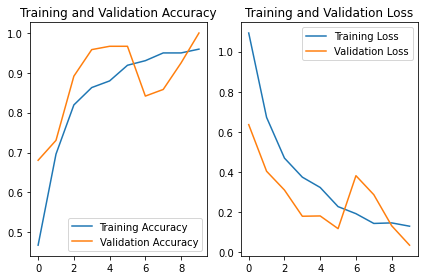

In [20]:
# Plot the training and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()